# Comparison of SNN and CNN on LFPs Recorded from Mice

In this notebook, we explore the performance of Spiking Neural Networks (SNN) and Convolutional Neural Networks (CNN) for analyzing Local Field Potentials (LFPs) recorded from mice. LFPs provide valuable insights into the neural activity at the population level, capturing oscillatory patterns and synchronous neuronal firing.

## Objectives
- Evaluate the performance metrics such as accuracy, precision, recall, and F1-score.
- Showcase the strengths and limitations of each model in analyzing LFPs.

This notebook aims to validate the effectiveness of SNN in detecting Sharp Wave Ripples.

In [1]:
# IMPORTS
import sys
import numpy as np
sys.path.insert(0, '../')
sys.path.insert(0, '../../trainSNN/')
sys.path.insert(0, '../../liset_tk/')
sys.path.insert(0, '../../utils/')
from liset_tk import liset_tk
from liset_aux import load_ripple_times
from signal_aid import *
from eval import modelEval
from plots.plot_line import create_fig
from models import torchSNN

SHNK_CHANNEL_OF_STUDY = 5 # Channel for doing the predictions in the SNN (Aparently the better)

### **Load the data with `liset_tk()` module**

If a competent computer is available run here:

In [2]:
data_paths = [
    '../../../CNN_TRAINING_SESSIONS/Amigo2_1_hippo_2019-07-11_11-57-07_1150um',
    '../../../CNN_TRAINING_SESSIONS/Som_2_hippo_2019-07-24_12-01-49_1530um'
]

data_path = data_paths[0]
data_loader = liset_tk(data_path, shank=3, downsample=4000, start=4000000, numSamples=1000000)
channel = bandpass_filter(data_loader.data[:, 5], [100, 250], data_loader.fs) # Filter the channel of interest

Downsampling data from 30000 Hz to 4000 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (133333, 8)


Load the ripples for later validation

In [3]:
ripple_times = load_ripple_times(data_path)

In [5]:
ripple_times.shape

(1309, 2)

Alternatively run it in smaller chunks to avoid memory issues

In [4]:
import os
data_path = data_paths[0] # Change accordingly to the current dataset
samples = os.path.getsize(data_path + '/lfp.dat') / 43 / 4
batch_size = 5000000
SNN_output = []
channel_long = []

for batch in range(int(samples / batch_size) + 1):
    start = batch * batch_size
    Som_2 = liset_tk(data_path, shank=3, downsample=4000, start=start, numSamples=batch_size, verbose=False)
    channel = bandpass_filter(Som_2.data[:, SHNK_CHANNEL_OF_STUDY], [100, 250], Som_2.fs) # Filter the channel of interest
    channel_long.append(channel)

    print(f'Batch: {batch} of {int(samples / batch_size)}', end='\r')

# Convert the channel to spikes
print('Converting channel to spikes ...')
channel = np.concatenate(channel_long)
spikes = y_discretize_1Dsignal(channel, 50)
del Som_2, channel_long

Converting channel to spikes ...


In [51]:
# Save the channel for later faster loading with numpy
np.save('../../../bootstrap_data/spikes_chann_Som_2.npy', arr=spikes, allow_pickle=True)

## **Predict with CNN model**

Predict through the loaded data

In [ ]:
data_path = '../../../CNN_TRAINING_SESSIONS/Amigo2_1_hippo_2019-07-11_11-57-07_1150um'
liset = liset_tk(data_path, shank=3, downsample=1250, start=4000000, numSamples=1000000)

liset.load_model('CNN')
liset.predict(threshold=0.3) # Optimized for performance metrics
CNN_preds = liset.prediction_idxs

In [9]:
# If no high memory available run through small batches
import os
data_path = '../../../CNN_TRAINING_SESSIONS/Som_2_hippo_2019-07-24_12-01-49_1530um'
samples = os.path.getsize(data_path + '/lfp.dat') / 43 / 2
batch_size = 5000000
channels_long = []

for batch in range(int(samples / batch_size) + 1):
    start = batch * batch_size
    Som_2 = liset_tk(data_path, shank=3, downsample=1250, start=start, numSamples=batch_size, verbose=False)
    channels_long.append(Som_2.data)

    print(f'Batch: {batch} of {int(samples / batch_size)}', end='\r')


Som_2_data = np.concatenate(channels_long)
del channels_long
# Set the liset data to the whole data
Som_2.data = Som_2_data
Som_2.verbose = True

In [11]:
# Load model and inference with it
Som_2.load_model('CNN')
Som_2.predict(threshold=0.3)
CNN_preds = Som_2.prediction_idxs

Otherwise load previoulsy computed CNN predictions

In [38]:
CNN_preds = np.load('../data/CNN_preds_Amigo2.npy') * (4000/1250)

Evaluate the predicions

In [12]:
validateCNN = modelEval(ripple_times * 1250, 'CNN', title='Som_2')

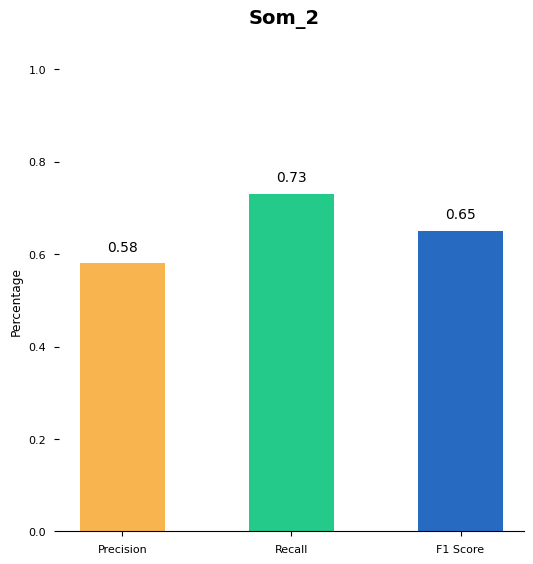

In [26]:
validateCNN(CNN_preds, chart='../img/perf_CNN_Som_2.svg')

## **Load SNN model and do predictions on loaded data**

Load the data and model

In [5]:
snn_path ='../../trainSNN/optimized_model/pytorchNetwork/256_128/E50_Y50/network.pt'
net = torchSNN(snn_path)

Predict on the spiking data

In [31]:
spikes = np.load('../../../bootstrap_data/spikes_chann_Amigo2.npy')

: 

In [8]:
spikes.shape

(50, 5333336)

In [9]:
import os

# Divide on chunks for 
samples = spikes.shape[1]
batch_size = 10000
SNN_output = []
SNN_output_long = []

for batch in range(int(samples / batch_size)):
    start = batch * batch_size
    output = net(spikes[:, start:(start + batch_size)])
    SNN_output_long.append(output)

    print(f'Batch: {batch} of {int(samples / batch_size)}', end='\r')

output = net(spikes[:, (batch+1)*batch_size:])
SNN_output_long.append(output)

# Convert the channel to spikes
SNN_output = np.concatenate(SNN_output_long)
# np.save('../../../bootstrap_data/SNN_output_Amigo2.npy', arr=SNN_output, allow_pickle=True)

Otherwise load the previously predicted output

In [28]:
import numpy as np
SNN_output = np.load('../../../bootstrap_data/SNN_output_Amigo2.npy')
SNN_output[SNN_output==0] = None
SNN_preds = detect_rate_increase(SNN_output, window_size=130, threshold=30)

In [ ]:
# Alternatively load the predicted ripples by SNN model
SNN_preds = np.load('../../data/pytorchSNN_predictions2.npy')

Evaluate the predictions

In [17]:
validateSNN = modelEval(ripple_times * 4000, 'SNN')

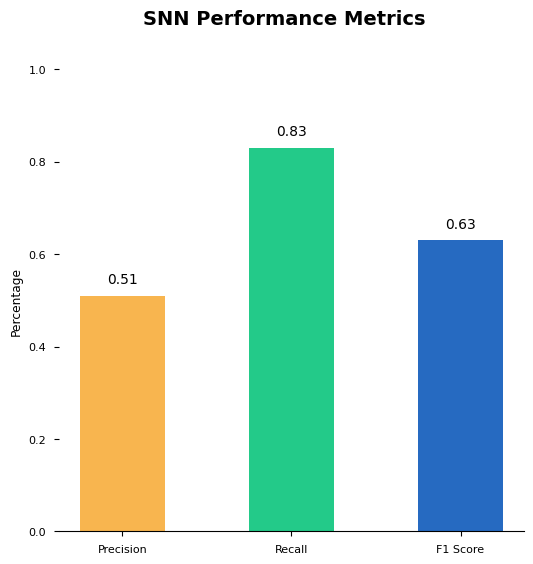

In [27]:
validateSNN(SNN_preds, chart='../img/perf_SNN_Som_2.svg')

## **Visualize the predictions**

### **Create interactive plot**

In [ ]:
start, stop = 0, 250000
fs = liset.fs
x = np.arange(start/fs, stop / fs, 1/fs)

hfo_plot = create_fig(
    title = 'Validation test',
    x_axis_label='Time (s)',
    y_axis_label='',
    x = x,
    y_arrays=[
        [channel[start:stop] - 5, 'Filtered LFPs'],
        ],
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right"
    )

scatter_plot = hfo_plot.scatter(x, SNN_output[start:stop] * -7, size=2, color="Black", alpha=0.6, legend_label="SNN Output")

hfo_plot.xgrid.visible = False
hfo_plot.ygrid.visible = False

In [ ]:
from bokeh.models import BoxAnnotation

# GROUND TRUTH
mask_ripples = (ripples[:, 1] >= start) & (ripples[:, 0] <= stop)
window_GT = ripples[mask_ripples] / fs

for ripple in window_GT:
    vfill = BoxAnnotation(left=ripple[0], right=ripple[1], fill_alpha=0.3, fill_color='#EC6F8F')
    hfo_plot.add_layout(vfill)

# SNN 
mask_SNN = (SNN_preds[:, 1] >= start) & (SNN_preds[:, 0] <= stop)
window_SNN = SNN_preds[mask_SNN] / fs

for pred in window_SNN:
    vfill = BoxAnnotation(left=pred[0], right=pred[1], fill_alpha=0.3, fill_color='#F7E290')
    hfo_plot.add_layout(vfill)

# CNN
mask_CNN = (CNN_preds[:, 1] >= start) & (CNN_preds[:, 0] <= stop)
window_CNN = CNN_preds[mask_CNN] / fs

for pred in window_CNN:
    vfill = BoxAnnotation(left=pred[0], right=pred[1], fill_alpha=0.3, fill_color='#266AC1')
    hfo_plot.add_layout(vfill)

# STYLINGS
hfo_plot.yaxis.axis_line_color = None
hfo_plot.yaxis.major_tick_line_color = None
hfo_plot.yaxis.minor_tick_line_color = None
hfo_plot.yaxis.major_label_text_font_size = '0pt'

### **Save as html and explore dynamically**

In [ ]:
import bokeh.plotting as bplt

file_path = f"validation_test_plain.html"

# Customize the output file settings
bplt.output_file(filename=file_path, title="Voltage dynamics across time")

# Save the plot
bplt.save(hfo_plot)

### **Plot the region of interest**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

# Set the window of interest
start, stop = 17.6 * 4000, 18.6 *4000
# Define plotting variables
x = np.arange(start/fs, stop / fs, 1/fs) # X axis vector
data = channel[int(start):int(stop)]
color = '#316AB3'
min, max = np.min(data) * 1.1, np.max(data) * 1.1 # Give margin for the fills

# Extract the events of that window (GT, predictions) --> (start, stop)
# GT
mask_ripples = (ripples[:, 1] >= start) & (ripples[:, 0] <= stop)
window_GT = ripples[mask_ripples] / fs

# SNN 
mask_SNN = (SNN_preds[:, 1] >= start) & (SNN_preds[:, 0] <= stop)
window_SNN = SNN_preds[mask_SNN] / fs

# CNN
mask_CNN = (CNN_preds[:, 1] >= start) & (CNN_preds[:, 0] <= stop - 100)
window_CNN = CNN_preds[mask_CNN] / fs


# Plot
plt.style.use('seaborn-v0_8-paper')
plt.figure(0, figsize=(20,10))
fig, ax = plt.subplots(1,1, figsize=(20,10))

fill_LFP, = ax.plot(x, liset.data[int(start):int(stop), 5] + 2, color='#54B479')
fill_filtered, = ax.plot(x, data - 4, color=color)
ax.plot(x, data - 8, color=color)
ax.plot(x, data - 12, color=color)

# Fill the areas of the events
for ripple in window_GT:
    vfill = '#EC6F8F'
    plt.fill_between(ripple, min - 4, max - 4, color=vfill, alpha=0.3)
    

for pred in window_SNN:
    vfill = '#F7E290'
    plt.fill_between(pred, min - 8, max - 8, color=vfill, alpha=0.3)

for pred in window_CNN:
    vfill = '#266AC1'
    plt.fill_between(pred, min - 12, max - 12, color=vfill, alpha=0.3)

fill_GT = Patch(color='#EC6F8F', alpha=0.3, label='Ground Truth')
fill_SNN = Patch(color='#F7E290', alpha=0.3, label='SNN')
fill_CNN = Patch(color='#266AC1', alpha=0.3, label='CNN')

labels = ['LFPs', 'Filtered LFPs', 'Ground Truth', 'SNN', 'CNN']
fills = [fill_LFP, fill_filtered, fill_GT, fill_SNN, fill_CNN]

# Stylings
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='x', labelsize=10)

plt.legend(fills, labels, fontsize=10)
plt.xlabel('Time (s)',fontsize=11)
font_properties = FontProperties(size=18, weight='bold')
text = plt.suptitle('SNN vs CNN', x=0.5, y=0.9, fontproperties=font_properties)

# Save the plot as .svg
# plt.savefig('../img/SNN_vs_CNN.svg', format='svg', bbox_inches='tight', pad_inches=0)